## Import Libralies

In [3]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score

import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Read the data file

In [4]:
def read_datafile(filepath):
    """reads the data file and pastes into a data frame."""
    df = pd.read_csv(filepath)
    return df

filepath = 'Wholesale customers data.csv'
df = read_datafile(filepath)

print("Data Overview:")
df.info()

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
print(f"\nData Shape: {df.shape}")
print(f"Null Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")


Data Shape: (440, 8)
Null Values: 0
Duplicate Rows: 0


## Exploratory Data Analysis

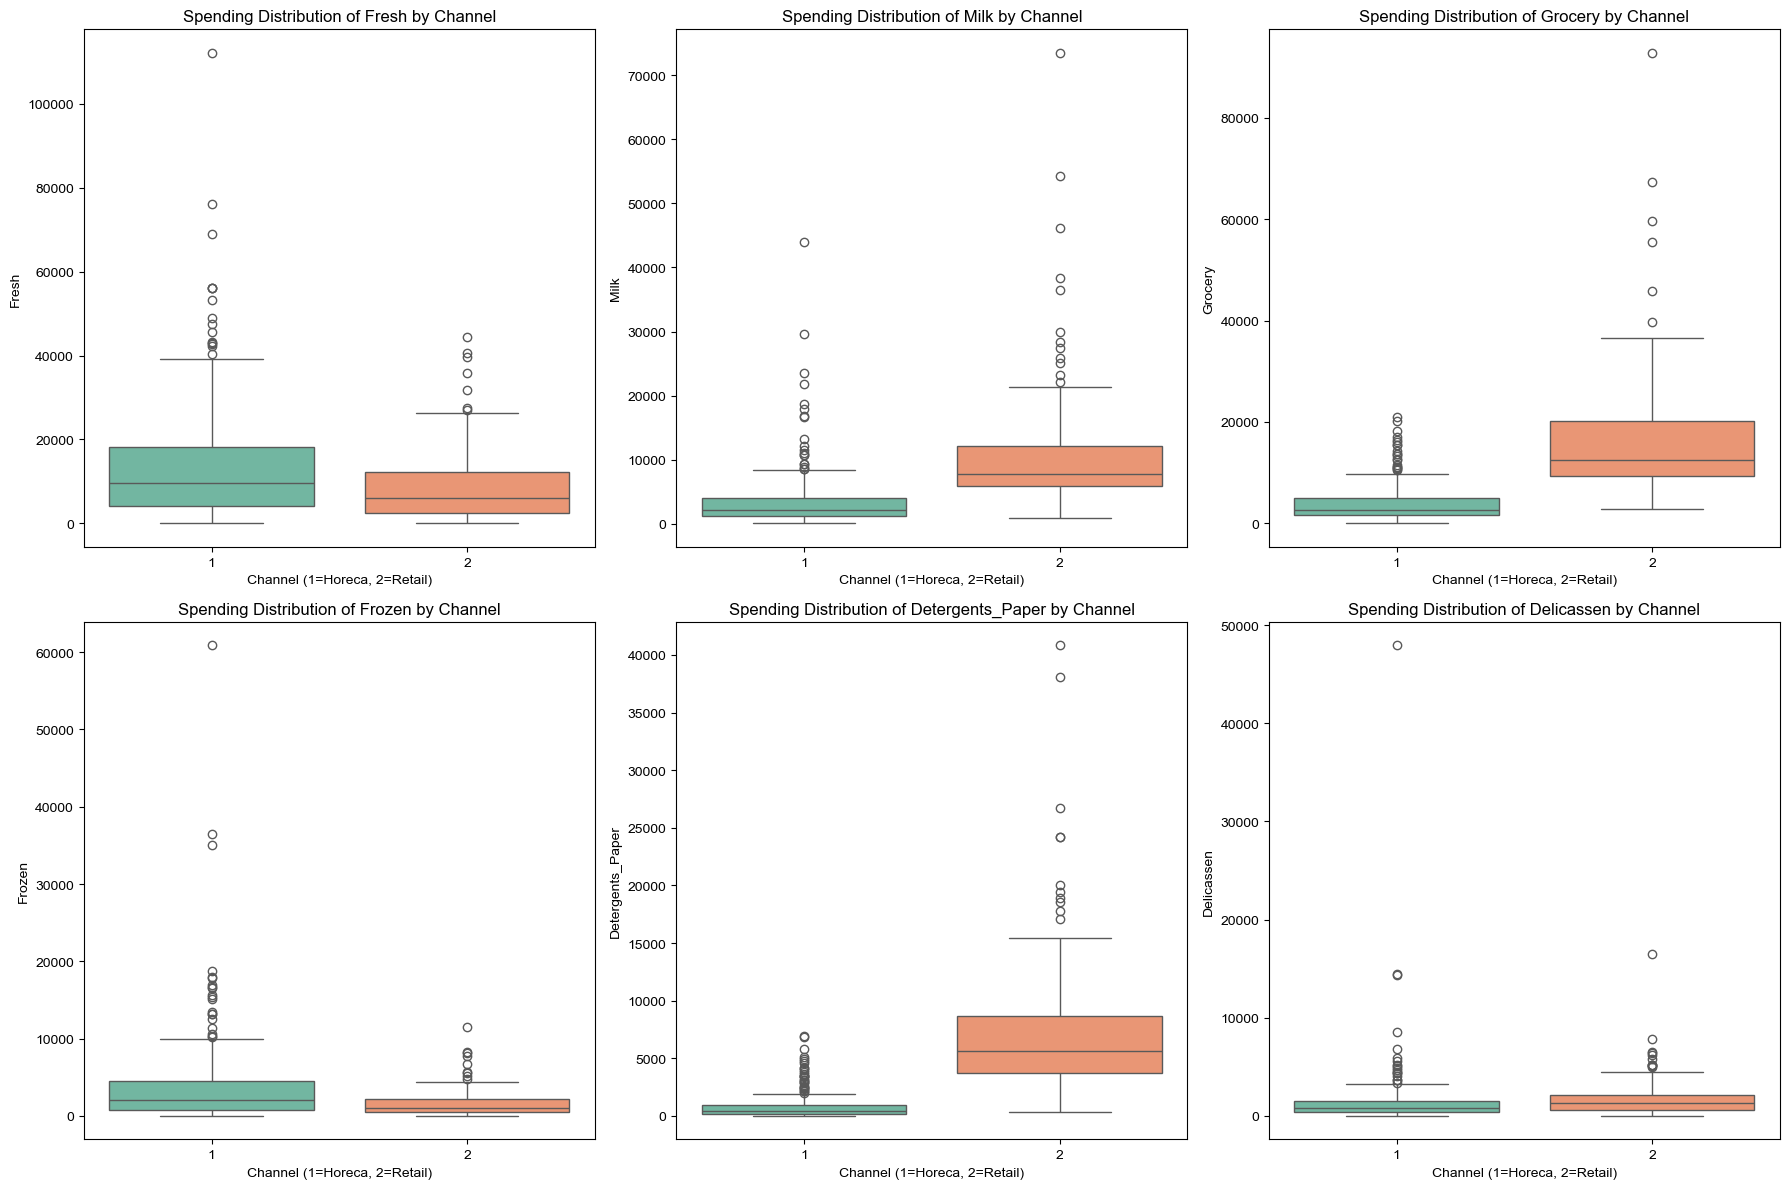

In [6]:
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.style.use('seaborn-v0_8-whitegrid')
axes = axes.flatten()

# Loop through each spending feature and plot its distribution by Channel
for i, feature in enumerate(spending_features):
    sns.boxplot(x='Channel', y=feature, data=df, ax=axes[i], palette='Set2', hue='Channel', legend=False)
    axes[i].set_title(f'Spending Distribution of {feature} by Channel')
    axes[i].set_xlabel('Channel (1=Horeca, 2=Retail)')

plt.tight_layout()
plt.show()

## Data Preprocesing

In [7]:
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_log = df.copy()

# Apply log(x+1) transformation
df_log[spending_features] = np.log1p(df_log[spending_features])

## 3.2. Standard Scaling and Encoding
# One Hot Encoding for 'Channel' and 'Region'
df_encoded = pd.get_dummies(df_log, columns=['Channel', 'Region'], drop_first=False)
X_features = df_encoded.columns

# Apply Standard Scaling
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(df_encoded.values)
X_scaled = pd.DataFrame(X_scaled_array, columns=df_encoded.columns)

print(f"Shape of scaled data: {X_scaled.shape}")

Shape of scaled data: (440, 11)


## Data Preprocessing

In [8]:
## 3.1. Log Transformation
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_log = df.copy()

# Apply log(x+1) transformation
df_log[spending_features] = np.log1p(df_log[spending_features])

## 3.2. Standard Scaling and Encoding
# One Hot Encoding for 'Channel' and 'Region'
df_encoded = pd.get_dummies(df_log, columns=['Channel', 'Region'], drop_first=False)
X_features = df_encoded.columns

# Apply Standard Scaling
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(df_encoded.values)
X_scaled = pd.DataFrame(X_scaled_array, columns=df_encoded.columns)

print(f"Shape of scaled data: {X_scaled.shape}")

Shape of scaled data: (440, 11)


## K-Means Baseline Model Exploration

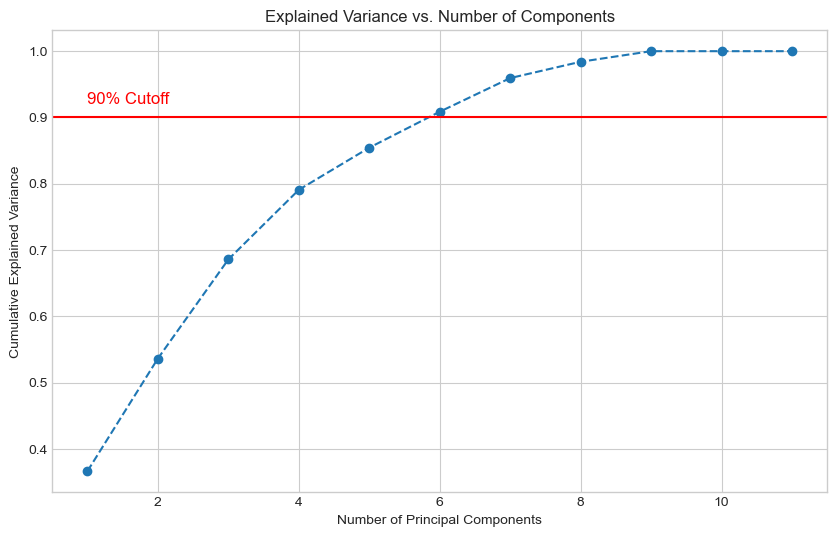

In [9]:
## 4.1. PCA Explained Variance (Finding N=6 Baseline)
pca_analysis = PCA(n_components=None, random_state=42)
pca_analysis.fit(X_scaled)
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(1, 0.92, '90% Cutoff', color = 'red', fontsize=12)
plt.grid(True)
plt.show()

In [10]:
# Find the 90% variance cutoff (N=6)
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
print(f"\nTotal Features: {X_scaled.shape[1]}")
print(f"Number of components needed to explain 90% variance: {n_components_90}")

# Create the N=6 baseline PCA data for k-exploration
pca_baseline = PCA(n_components=n_components_90, random_state=42)
X_pca_baseline = pca_baseline.fit_transform(X_scaled) 
print(f"\nShape of the baseline PCA data (X_pca_baseline) using N={n_components_90}: {X_pca_baseline.shape}")


Total Features: 11
Number of components needed to explain 90% variance: 6

Shape of the baseline PCA data (X_pca_baseline) using N=6: (440, 6)


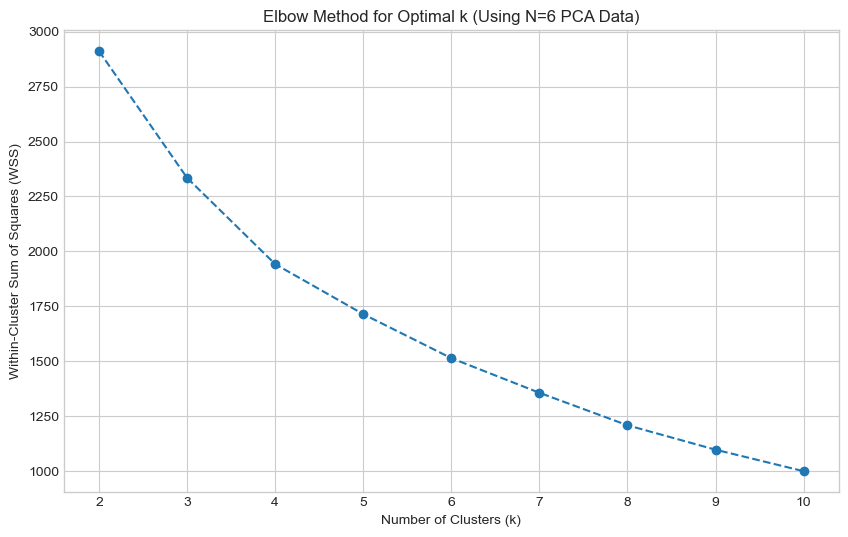

In [11]:
## 4.2. K-Means: Find Optimal k (Elbow Plot)
k_range = range(2, 11) 
wss = [] 
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    kmeans.fit(X_pca_baseline) # Using N=6 baseline data
    wss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Using N=6 PCA Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [12]:
## 4.3. K-Means: Find Optimal k (Silhouette Score)
silhouette_scores = {} 
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    kmeans.fit(X_pca_baseline) # Using N=6 baseline data
    score = silhouette_score(X_pca_baseline, kmeans.labels_)
    silhouette_scores[k] = score

scores_df = pd.DataFrame(list(silhouette_scores.items()), columns=['k', 'Silhouette_Score']).set_index('k')
print("Baseline Silhouette Scores (N=6 Data):")
print(scores_df.sort_values(by='Silhouette_Score', ascending=False))
# This confirms k=4 is the best choice.

Baseline Silhouette Scores (N=6 Data):
    Silhouette_Score
k                   
4           0.398673
3           0.358318
2           0.354736
7           0.341163
10          0.340652
9           0.337775
8           0.329810
6           0.322746
5           0.299190


## K-Means Model Optimization (Finding Optimal N)

In [13]:
# We now test different N-components (3, 4, 6, 8, 10) to see which one
# maximizes the Silhouette Score for our chosen k=4.
components_to_test = [3, 4, 6, 8, 10]
optimal_k = 4 
component_scores = {}

# Fit PCA with max components first
pca_max = PCA(n_components=X_scaled.shape[1], random_state=42)
X_pca_full = pca_max.fit_transform(X_scaled)

print(f"\n--- Optimizing N_Components for k={optimal_k} ---")
for n_comp in components_to_test:
    X_subset = X_pca_full[:, :n_comp]
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=200, random_state=42)
    kmeans.fit(X_subset)
    score = silhouette_score(X_subset, kmeans.labels_)
    component_scores[n_comp] = score

comp_scores_df = pd.DataFrame(list(component_scores.items()), 
                         columns=['N_Components', 'Silhouette_Score']).set_index('N_Components')

print("Silhouette Scores by Number of PCA Components:")
print(comp_scores_df.sort_values(by='Silhouette_Score', ascending=False))
print("\nConclusion: N=3 gives the highest Silhouette Score (0.4845).")


--- Optimizing N_Components for k=4 ---
Silhouette Scores by Number of PCA Components:
              Silhouette_Score
N_Components                  
3                     0.484542
4                     0.482692
6                     0.398673
8                     0.364688
10                    0.357083

Conclusion: N=3 gives the highest Silhouette Score (0.4845).


## Final Model 1: K-Means (N=3, k=4)

In [23]:
N_COMPONENTS_FINAL = 3
OPTIMAL_K = 4

# Apply PCA with the OPTIMAL N=3
pca_final_optimized = PCA(n_components=N_COMPONENTS_FINAL, random_state=42)
X_pca_final = pca_final_optimized.fit_transform(X_scaled)

## 6.1. Fit Final K-Means Model
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=200, random_state=42)
kmeans.fit(X_pca_final)
y_pred = kmeans.labels_

# Add the cluster labels to the original DataFrame
df['Cluster'] = y_pred

## 6.2. K-Means Performance Metrics
final_silhouette = silhouette_score(X_pca_final, y_pred)
true_labels_proxy = df['Channel']
final_ari_score = adjusted_rand_score(true_labels_proxy, y_pred)

print(f"--- K-MEANS FINAL MODEL PERFORMANCE ---")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Adjusted Rand Index (ARI) Score: {final_ari_score:.4f}")

## 6.3. K-Means Cluster Interpretation (Profiling)
cluster_analysis = df.groupby('Cluster').mean(numeric_only=True)
print("\nK-Means Cluster Analysis (Mean values in ORIGINAL CURRENCY/COUNTS):")
print(cluster_analysis)

--- K-MEANS FINAL MODEL PERFORMANCE ---
Silhouette Score: 0.4845
Adjusted Rand Index (ARI) Score: 0.5347

K-Means Cluster Analysis (Mean values in ORIGINAL CURRENCY/COUNTS):
          Channel    Region         Fresh          Milk       Grocery  \
Cluster                                                                 
0        1.972222  3.000000  10644.527778  11078.074074  15898.546296   
1        1.000000  3.000000  13514.269231   3328.495192   3741.384615   
2        1.972973  1.486486   5894.297297  10231.729730  17715.945946   
3        1.011494  1.333333  12660.517241   3253.149425   3997.942529   

              Frozen  Detergents_Paper   Delicassen  Cluster_GMM  
Cluster                                                           
0        1630.546296       6880.490741  1868.990741     1.009259  
1        3626.889423        708.254808  1491.629808     1.975962  
2        1772.972973       8468.810811  1517.243243     2.756757  
3        4086.873563        736.793103  1180.402299 

## K-Means Visualization (with Centroids)

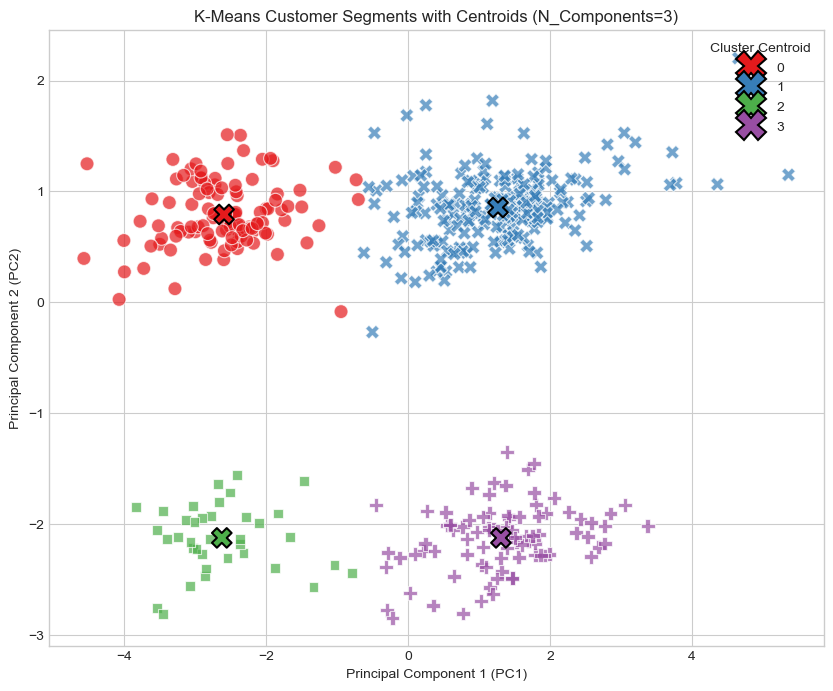

In [16]:
pca_df = pd.DataFrame(X_pca_final[:, 0:2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = y_pred

# Extract and prepare Centroids
centroids = kmeans.cluster_centers_[:, 0:2]
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2'])
centroids_df['Cluster'] = range(OPTIMAL_K) 

# Create the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='Set1', 
    style='Cluster',
    s=100,
    alpha=0.7,
    legend=False
)
sns.scatterplot(
    data=centroids_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='Set1',
    marker='X',
    s=200, 
    edgecolor='black',
    linewidth=1.5,
    legend='full'
)
plt.title(f'K-Means Customer Segments with Centroids (N_Components={N_COMPONENTS_FINAL})')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Cluster Centroid', loc='upper right', markerscale=1.5)
plt.grid(True)
plt.show()

## K-Means Intersection Matrix


K-Means Final Intersection Matrix (True Channel vs. Predicted Clusters):
                  Cluster 0  Cluster 1  Cluster 2  Cluster 3
True: Horeca (1)          3        208          1         86
True: Retail (2)        105          0         36          1


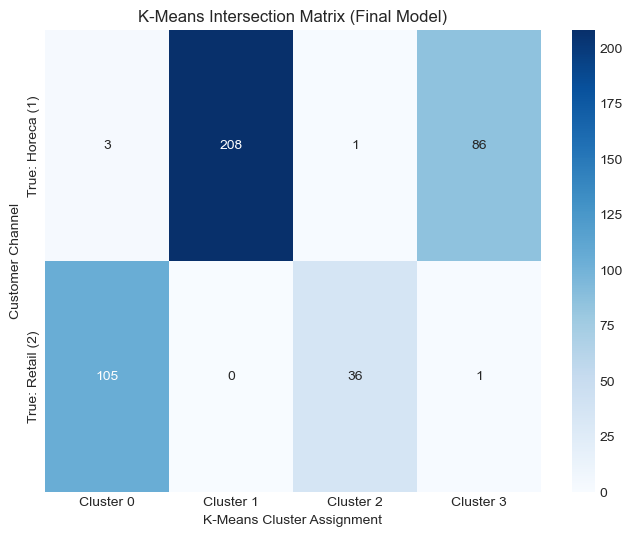

In [17]:
cm_df = pd.crosstab(index=df['Channel'], columns=df['Cluster'], 
                    rownames=['True Channel'], colnames=['Cluster Prediction'])

cm_df.index = ['True: Horeca (1)', 'True: Retail (2)']
cm_df.columns = [f'Cluster {c}' for c in cm_df.columns]

print("\nK-Means Final Intersection Matrix (True Channel vs. Predicted Clusters):")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('K-Means Intersection Matrix (Final Model)')
plt.xlabel('K-Means Cluster Assignment')
plt.ylabel('Customer Channel')
plt.show()


## Model 2: GMM Comparison (N = 3)

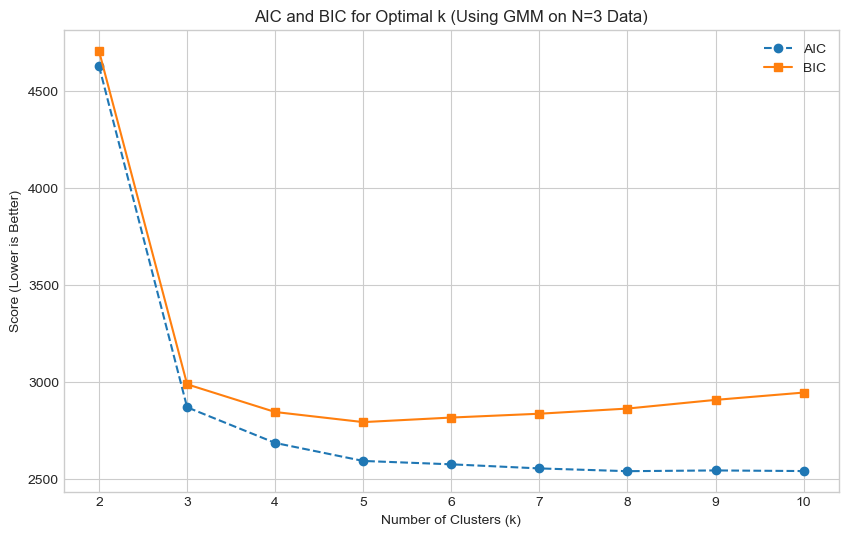

In [19]:
## 7.1. GMM: Find Optimal k (AIC/BIC)
# We test GMM on the *same optimized N=3 data* for a fair comparison.
k_range = range(2, 11) 
aic_scores = []
bic_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X_pca_final) # Using N=3 optimized data
    aic_scores.append(gmm.aic(X_pca_final))
    bic_scores.append(gmm.bic(X_pca_final))

# Plot the AIC/BIC curves
plt.figure(figsize=(10, 6))
plt.plot(k_range, aic_scores, marker='o', linestyle='--', label='AIC')
plt.plot(k_range, bic_scores, marker='s', linestyle='-', label='BIC')
plt.title('AIC and BIC for Optimal k (Using GMM on N=3 Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score (Lower is Better)')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()
# The plot shows BIC minimum at k=4.

## GMM Fit and Evaluation

In [20]:
## 7.2. GMM Fit and Evaluation
# Based on your notes and the BIC plot, k=4 is the optimal choice.
OPTIMAL_K_GMM = 4 
N_COMPONENTS_FINAL = 3 

# Fit the Final GMM Model
gmm = GaussianMixture(n_components=OPTIMAL_K_GMM, random_state=42, n_init=10)
gmm.fit(X_pca_final) 
y_pred_gmm = gmm.predict(X_pca_final)

# Add the GMM cluster labels to a new column
df['Cluster_GMM'] = y_pred_gmm

# GMM Performance Metrics
final_silhouette_gmm = silhouette_score(X_pca_final, y_pred_gmm)
final_ari_score_gmm = adjusted_rand_score(df['Channel'], y_pred_gmm)

print(f"--- GMM FINAL MODEL PERFORMANCE ---")
print(f"Silhouette Score (GMM): {final_silhouette_gmm:.4f}")
print(f"Adjusted Rand Index (ARI) Score (GMM): {final_ari_score_gmm:.4f}")

--- GMM FINAL MODEL PERFORMANCE ---
Silhouette Score (GMM): 0.4818
Adjusted Rand Index (ARI) Score (GMM): 0.5083


## GMM Cluster Interpretation and Matrix

In [21]:
# GMM Cluster Profiling
cluster_analysis_gmm = df.groupby('Cluster_GMM').mean(numeric_only=True)
print("\nCluster Analysis (GMM Mean values):")
print(cluster_analysis_gmm)

# GMM Intersection Matrix
cm_df_gmm = pd.crosstab(index=df['Channel'], columns=df['Cluster_GMM'], 
                    rownames=['True Channel'], colnames=['GMM Cluster Prediction'])
cm_df_gmm.index = ['True: Horeca (1)', 'True: Retail (2)']
cm_df_gmm.columns = [f'Cluster {c}' for c in cm_df_gmm.columns]

print("\nFinal Intersection Matrix (GMM):")
print(cm_df_gmm)


Cluster Analysis (GMM Mean values):
              Channel    Region         Fresh          Milk       Grocery  \
Cluster_GMM                                                                 
0            1.033333  1.322222  12423.700000   3358.944444   4158.211111   
1            1.937500  3.000000   9267.517857  10620.258929  15488.482143   
2            1.000000  3.000000  14326.544118   3427.892157   3728.142157   
3            2.000000  1.529412   5924.147059  10567.441176  18502.117647   

                  Frozen  Detergents_Paper   Delicassen   Cluster  
Cluster_GMM                                                        
0            4120.722222        796.355556  1206.444444  2.966667  
1            1433.553571       6700.562500  1744.910714  0.044643  
2            3774.186275        686.014706  1552.352941  0.995098  
3            1479.205882       8993.382353  1478.029412  2.000000  

Final Intersection Matrix (GMM):
                  Cluster 0  Cluster 1  Cluster 2  Cluster

## Final Conclusion

In [22]:
print("\n" + "="*50)
print(" FINAL MODEL COMPARISON")
print("="*50)
print(f"K-Means (N=3, k=4): \t Silhouette = {final_silhouette:.4f} \t ARI = {final_ari_score:.4f}")
print(f"GMM (N=3, k=4): \t Silhouette = {final_silhouette_gmm:.4f} \t ARI = {final_ari_score_gmm:.4f}")
print("\nConclusion: The optimized K-Means model is the superior choice, as it provides")
print("a slightly higher Silhouette Score and a stronger alignment (ARI) with the")
print("known business channels (Horeca/Retail).")


 FINAL MODEL COMPARISON
K-Means (N=3, k=4): 	 Silhouette = 0.4845 	 ARI = 0.5347
GMM (N=3, k=4): 	 Silhouette = 0.4818 	 ARI = 0.5083

Conclusion: The optimized K-Means model is the superior choice, as it provides
a slightly higher Silhouette Score and a stronger alignment (ARI) with the
known business channels (Horeca/Retail).
